In [114]:
## Plotting Colors:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, ColorConverter
import matplotlib.cm as cm
from matplotlib.colors import Normalize, to_rgba_array, to_hex
import seaborn as sns


# Numpy display options: Very useful, uses the whole width of the screen
np.set_printoptions(edgeitems=3, linewidth=4096, 
    formatter=dict(float=lambda x: "%.3g" % x))
np.core.arrayprint._line_width = 144


class PhoColors:
    """ A convenience class for managing good combinations of colors for data visualization and extending colormaps dynamically """
    class Colors:
        @property
        def active_rgba_colors(self):
            return to_rgba_array(PhoColors.Colors.extended_tab20b_main_colors_hex()) # np.shape(tab20b_main_rgba_colors) # (5, 4)

        @property
        def active_rgb_colors(self):
             return self.active_rgba_colors[:,:-1] # np.shape(tab20b_main_rgb_colors) # (5, 3)

        @property
        def active_cmap(self):
             return matplotlib.colors.ListedColormap(self.active_rgba_colors)

        @staticmethod
        def extended_tab20b_main_colors_hex():
            c_weird_bright_orange = '#b25809'
            # c_weird_orange = '#846739'
            c_dark_teal = '#397084'
            pho_modified_tab20b_main_colors_hex = ['#843c39', c_weird_bright_orange, '#8c6d31', '#637939', c_dark_teal, '#393b79', '#7b4173']
            return pho_modified_tab20b_main_colors_hex

    colors = Colors()
    
    @staticmethod
    def pho_categorical_colormap(n_needed_colors, colors: np.array):
        """ Builds a larger colormap with lumance adjusted variations of the colors in the provided colors array
        Inputs:
            colors should have two axis: the single_color_axis (of size 3 or 4) and the data_axis (of size N) 
        
        Usage:
            PhoColors.pho_categorical_colormap(40, PhoColors.colors.active_rgba_colors)
        """
        colors_shape = np.shape(colors) # colors_shape: (5, 3)
        print(f'colors_shape: {np.shape(colors)}')
        if ((colors_shape[0] != 3) and (colors_shape[0] != 4)):
            # expected form
            pass
        else:
            assert ((colors_shape[0] == 3) or (colors_shape[0] == 4)), "No dimension of colors array is of length 3 or 4. This should be RGB or RGBA data."
            colors = colors.T # transpose the colors so they're in the correct form:
            colors_shape = np.shape(colors)

        single_color_axis = 1
        data_axis = 0
        base_colormap_n_colors = colors_shape[data_axis]
        needed_single_hue_variations = int(np.ceil(n_needed_colors / base_colormap_n_colors)) # for n_colors = 40, needed_repeats = 2
        print(f'needed_single_hue_variations: {needed_single_hue_variations}, base_colormap_n_colors: {base_colormap_n_colors}, n_needed_colors: {n_needed_colors}')
        # cmap = categorical_cmap(base_colormap_n_colors, needed_single_hue_variations, cmap=cmap, continuous=False)
        return PhoColors.categorical_cmap_from_colors(base_colormap_n_colors, needed_single_hue_variations, ccolors=colors)

    
    @staticmethod
    def categorical_subdivide_colors(ccolors, nc, nsc):
        cols = np.zeros((nc*nsc, 3))
        for i, c in enumerate(ccolors):
            chsv = matplotlib.colors.rgb_to_hsv(c[:3])
            arhsv = np.tile(chsv,nsc).reshape(nsc,3)
            arhsv[:,1] = np.linspace(chsv[1],0.25,nsc)
            arhsv[:,2] = np.linspace(chsv[2],1,nsc)
            rgb = matplotlib.colors.hsv_to_rgb(arhsv)
            cols[i*nsc:(i+1)*nsc,:] = rgb       
        return cols

    @staticmethod
    def categorical_cmap(nc, nsc, cmap='tab20b', continuous=False):
        """ takes as input the number of categories (nc) and the number of subcategories (nsc) and returns a colormap with nc*nsc different colors, where for each category there are nsc colors of same hue.
            From https://stackoverflow.com/questions/47222585/matplotlib-generic-colormap-from-tab10

        """
        if isinstance(cmap, str):
            cmap = plt.get_cmap(cmap)

        if nc > cmap.N:
            raise ValueError("Too many categories for colormap.")
        if continuous:
            ccolors = cmap(np.linspace(0,1,nc))
        else:
            ccolors = cmap(np.arange(nc, dtype=int))
        cols = PhoColors.categorical_subdivide_colors(ccolors, nc, nsc)
        cmap = matplotlib.colors.ListedColormap(cols)
        return cmap


    @staticmethod
    def categorical_cmap_from_colors(nc, nsc, ccolors, continuous=False):
        """ takes as input the number of categories (nc) and the number of subcategories (nsc) and returns a colormap with nc*nsc different colors, where for each category there are nsc colors of same hue.
            From https://stackoverflow.com/questions/47222585/matplotlib-generic-colormap-from-tab10
        """
        cols = PhoColors.categorical_subdivide_colors(ccolors, nc, nsc)
        cmap = matplotlib.colors.ListedColormap(cols)
        return cmap


    
    
def get_neuron_colors(sort_indicies, cmap="tab20b"):
    # returns the list of colors, an RGBA np.array of shape: 4 x n_neurons. 
    cmap = mpl.cm.get_cmap(cmap)
    n_neurons = len(sort_indicies)
    colors_array = np.zeros((4, n_neurons))
    for i, neuron_ind in enumerate(sort_indicies):
        colors_array[:, i] = cmap(i / len(sort_indicies))
    return colors_array



def build_units_colormap(neuron_ids):
    """
    
    Example:
        good_placefield_neuronIDs = np.array([ 2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 14, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 29, 33, 34, 38, 39, 42, 44, 45, 46, 47, 48, 53, 55, 57, 58, 61, 62, 63, 64])
        pf_sort_ind, pf_colors, pf_colormap, pf_listed_colormap = build_units_colormap(good_placefield_neuronIDs)
        
        ## OUTPUT:
        pf_sort_ind 
            array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])
        pf_colors 
            array([[0.224, 0.224, 0.322, 0.322, 0.42, 0.42, 0.612, 0.612, 0.388, 0.388, 0.549, 0.549, 0.71, 0.71, 0.808, 0.808, 0.549, 0.549, 0.741, 0.741, 0.906, 0.906, 0.906, 0.906, 0.518, 0.518, 0.678, 0.678, 0.839, 0.839, 0.906, 0.906, 0.482, 0.482, 0.647, 0.647, 0.808, 0.808, 0.871, 0.871],
           [0.231, 0.231, 0.329, 0.329, 0.431, 0.431, 0.62, 0.62, 0.475, 0.475, 0.635, 0.635, 0.812, 0.812, 0.859, 0.859, 0.427, 0.427, 0.62, 0.62, 0.729, 0.729, 0.796, 0.796, 0.235, 0.235, 0.286, 0.286, 0.38, 0.38, 0.588, 0.588, 0.255, 0.255, 0.318, 0.318, 0.427, 0.427, 0.62, 0.62],
           [0.475, 0.475, 0.639, 0.639, 0.812, 0.812, 0.871, 0.871, 0.224, 0.224, 0.322, 0.322, 0.42, 0.42, 0.612, 0.612, 0.192, 0.192, 0.224, 0.224, 0.322, 0.322, 0.58, 0.58, 0.224, 0.224, 0.29, 0.29, 0.42, 0.42, 0.612, 0.612, 0.451, 0.451, 0.58, 0.58, 0.741, 0.741, 0.839, 0.839],
           [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


    """
    pf_sort_ind = np.array([int(i) for i in np.arange(len(neuron_ids))]) # convert to integer scalar array
    pf_colors = get_neuron_colors(pf_sort_ind) # [4 x n_neurons]: colors are by ascending index ID
    pf_colormap = pf_colors.T # [n_neurons x 4] Make the colormap from the listed colors, used seemingly only by 'runAnalysis_PCAandICA(...)'
    pf_listed_colormap = ListedColormap(pf_colormap)
    return pf_sort_ind, pf_colors, pf_colormap, pf_listed_colormap

In [12]:
good_placefield_neuronIDs = np.array([ 2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 14, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 29, 33, 34, 38, 39, 42, 44, 45, 46, 47, 48, 53, 55, 57, 58, 61, 62, 63, 64])
pf_sort_ind, pf_colors, pf_colormap, pf_listed_colormap = build_units_colormap(good_placefield_neuronIDs)

In [14]:
pf_sort_ind # array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])

In [13]:
pf_colors

In [17]:
sns.color_palette('magma', n_colors=40)

In [24]:
sns.color_palette('tab20b', as_cmap=True)
# n_colors=40, 

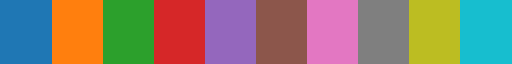

In [57]:
cmap = mpl.cm.get_cmap('tab10')
cmap

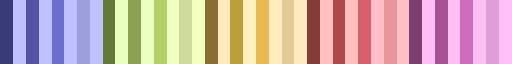

In [127]:



active_cmap_name = 'tab20b'
# active_cmap_name = 'tab10'
n_colors = 40
# max_num_hue_repeats = 3

base_colormap_n_colors = 20 # for 'tab20b'
needed_single_hue_variations = int(np.ceil(n_colors / base_colormap_n_colors)) # for n_colors = 40, needed_repeats = 2


categorical_cmap(base_colormap_n_colors, needed_single_hue_variations, cmap=active_cmap_name, continuous=False)
# categorical_cmap(10, 3, cmap='tab10', continuous=True)

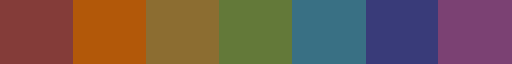

In [190]:
# Pho Custom colormap
# tab20b_main_colors_hex = ['#393b79', '#637939', '#8c6d31', '#843c39', '#7b4173']
# tab20b_main_colors_hex = ['#843c39', '#8c6d31', '#637939', '#393b79', '#7b4173'] # sorted
    
# orange: '#b25809'

# PhoColors.colors.active_rgb_colors
# active_rgba_colors = to_rgba_array(PhoColors.Colors.extended_tab20b_main_colors_hex()) # np.shape(tab20b_main_rgba_colors) # (5, 4)
# active_rgb_colors = active_rgba_colors[:,:-1] # np.shape(tab20b_main_rgb_colors) # (5, 3)

base_cmap = matplotlib.colors.ListedColormap(PhoColors.colors.active_rgba_colors)
# print(f'base_cmap.N: {base_cmap.N}')
# print(base_cmap)
base_cmap

colors_shape: (7, 4)
needed_single_hue_variations: 6, base_colormap_n_colors: 7, n_needed_colors: 40


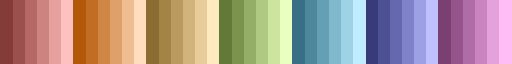

In [188]:
# n_colors = 40
# base_colormap_n_colors = base_cmap.N # for 'tab20b'
# needed_single_hue_variations = int(np.ceil(n_colors / base_colormap_n_colors)) # for n_colors = 40, needed_repeats = 2
# print(f'needed_single_hue_variations: {needed_single_hue_variations}, base_colormap_n_colors: {base_colormap_n_colors}, n_colors: {n_colors}')


# # cmap = categorical_cmap(base_colormap_n_colors, needed_single_hue_variations, cmap=cmap, continuous=False)
# cmap = categorical_cmap_from_colors(base_colormap_n_colors, needed_single_hue_variations, ccolors=tab20b_main_rgb_colors)
# cmap

PhoColors.pho_categorical_colormap(40, PhoColors.colors.active_rgba_colors)

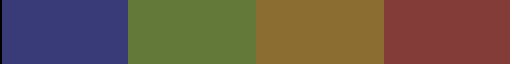

In [103]:
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return LinearSegmentedColormap('CustomMap', cdict)


curr_main_color_span_range = np.linspace(0.0, 1.0, len(tab20b_main_rgb_colors)) # array([0, 0.25, 0.5, 0.75, 1])
# tab20b_main_colors
c = ColorConverter().to_rgb
# rvb = make_colormap(
#     [c('red'), c('violet'), 0.33, c('violet'), c('blue'), 0.66, c('blue')])

rvb = make_colormap(
    # [c('red'), c('violet'), 0.33, c('violet'), c('blue'), 0.66, c('blue')]
    # totuple(tab20b_main_rgb_colors)
    [(0, 0, 0), curr_main_color_span_range[0],
    (0.2235294117647059, 0.23137254901960785, 0.4745098039215686), curr_main_color_span_range[1], 
     (0.38823529411764707, 0.4745098039215686, 0.2235294117647059), curr_main_color_span_range[2], 
     (0.5490196078431373, 0.42745098039215684, 0.19215686274509805), curr_main_color_span_range[3], 
     (0.5176470588235295, 0.23529411764705882, 0.2235294117647059), curr_main_color_span_range[4], 
     (0.4823529411764706, 0.2549019607843137, 0.45098039215686275), 1.0,
     (1.0, 1.0, 1.0)
    ]
)
rvb
# c('red') # (1.0, 0., 0.)
